In [6]:
import numpy
import time
import ipyparallel as ipp
from scipy import stats
from qiskit.aqua.operators.legacy import op_converter
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.problems.second_quantization.electronic.builders import fermionic_op_builder
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
#from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit.opflow import I,X,Y,Z,StateFn,AbelianGrouper
from openfermion.circuits import slater_determinant_preparation_circuit
from qiskit.quantum_info import Pauli
from qiskit import QuantumCircuit,execute,QuantumRegister,ClassicalRegister
from qiskit import Aer
from openfermion.linalg import givens_decomposition_square as givensRotns
from qiskit.opflow.primitive_ops import PauliSumOp
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliExpectation, CircuitSampler, CircuitStateFn 
import scipy
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.compiler import transpile
from qiskit.circuit.random import random_circuit
from qiskit.chemistry.components.variational_forms import UCCSD
from tqdm import tqdm
from qiskit.providers.aer import AerSimulator

In [7]:
import warnings
warnings. filterwarnings('ignore')

In [8]:
c = ipp.Client()
num_qubits=8

In [9]:
def qubitOp(h1,h2):
    fer_op=fermionic_op_builder.build_ferm_op_from_ints(h1,h2)
    mapper=JordanWignerMapper()
    qubit_op=mapper.map(fer_op)
    return qubit_op

In [10]:
def egBandHamiltonian(U):
    #Getting chemical Potential for Half-Filling
    with open('../chem_pot_for_Half_Fill.txt','r') as f:
        lines=f.readlines()[1:]
        for line in lines:
            elems=line.split()
            if int(elems[0])==U:
                muHalf=float(elems[1]) #Chem Pot for a given Hubbard U
    #Getting the one body and two body interaction vertexes
    with open('../'+str(U)+'/v1e.dat','r') as f:
            lines=f.readlines()[1:]
            num_sites=4
            chem_pot=numpy.zeros((2*num_sites,2*num_sites))
            eg_h1=numpy.zeros((2*num_sites,2*num_sites))
            for line in lines:
                elems=line.split()
                eg_h1[int(elems[0])][int(elems[1])]=float(elems[2])
                eg_h1[int(elems[0])+num_sites][int(elems[1])+num_sites]=float(elems[2])
            for i in range(2*num_sites):
                chem_pot[i][i]=-muHalf
            eg_h1=eg_h1+chem_pot       
    with open('../'+str(U)+'/v2e.dat','r') as f:
        num_sites=4
        eg_h2=numpy.zeros((2*num_sites,2*num_sites,2*num_sites,2*num_sites))
        for line in f:
            if "#" in line:
                continue
            line = line.split()
            i,j,k,l = map(int, line[:4])
            val = float(line[4])
            eg_h2[i,j,k,l] = eg_h2[i+num_sites,j+num_sites,k,l] = eg_h2[i,j,k+num_sites,l+num_sites] \
            = eg_h2[i+num_sites,j+num_sites,k+num_sites,l+num_sites] = 0.5*val  # convention with 0.5 factor included.
    qubitH=qubitOp(eg_h1,eg_h2)
    Hmat=qubitH.to_matrix(massive=True)
    w,v=numpy.linalg.eigh(Hmat)
    Eg=w[0]
    state_g=v[:,0]
    return qubitH,Hmat,Eg,state_g

In [11]:
#One particle density matrix-statevector
def one_RDM(data):
    import numpy
    from qiskit_nature.problems.second_quantization.electronic.builders import fermionic_op_builder
    from qiskit_nature.mappers.second_quantization import JordanWignerMapper
    state,num_qubits,i,j=data
    mapper=JordanWignerMapper()
    h1=numpy.zeros((num_qubits,num_qubits))*1j
    h2=numpy.zeros((num_qubits,num_qubits))*1j
    h1[i,j]=h1[j,i]=0.5
    h2[i,j]=0.5*1j
    h2[j,i]=-0.5*1j
    h1=fermionic_op_builder.build_ferm_op_from_ints(h1,numpy.zeros((num_qubits,num_qubits,num_qubits,num_qubits)))
    h2=fermionic_op_builder.build_ferm_op_from_ints(h2,numpy.zeros((num_qubits,num_qubits,num_qubits,num_qubits)))
    h1=mapper.map(h1)
    h2=mapper.map(h2)
    h1=h1.to_matrix(massive=True)
    h2=h2.to_matrix(massive=True)
    h=h1+1j*h2
    return state@h@state
def M(state):
    num_qubits=8
    arr=[(state,num_qubits,i,j) for i in range(num_qubits) for j in range(num_qubits) if i<=j]
    result = c[:].map_async(one_RDM, arr)
    M_arr=result.get()
    adapt_RDM=numpy.zeros((num_qubits,num_qubits))*1j
    ind=0
    for i in range(num_qubits):
        for j in range(i,num_qubits):
            adapt_RDM[i,j]=M_arr[ind]
            adapt_RDM[j,i]=numpy.conjugate(M_arr[ind])
            ind=ind+1
    return adapt_RDM
def dist(rho1,rho2):
    rho_diff=rho1-rho2
    entries=num_qubits*num_qubits
    d_12=numpy.sum(numpy.abs(rho_diff))/len(rho_diff[numpy.abs(rho_diff)>1e-3])#numpy.sqrt(numpy.sum(numpy.diag(numpy.dot(rho_diff,numpy.conjugate(rho_diff.T)))))
    return d_12

In [17]:
def HF_init_state(U):
    N=4
    # Qiskit implementation of Givens rotation
    def prepare_givens_rotated_state(givens):
        circ = QuantumCircuit(2*N)
        # Fill first N_f orbitals for each spin
        for i in range(N_f):
            circ.x(i)
            circ.x(i+N)
        for rots in givens:
            for tup in rots:
                #for spin down
                spin=0
                circ.cnot(tup[1]+N*spin,tup[0]+N*spin)
                circ.cry(-2*tup[2],tup[0]+N*spin, tup[1]+N*spin)
                circ.cnot(tup[1]+N*spin, tup[0]+N*spin)
                circ.rz(tup[3],tup[1]+N*spin)
                #for spin up
                spin=1
                circ.cnot(tup[1]+N*spin,tup[0]+N*spin)
                circ.cry(-2*tup[2],tup[0]+N*spin, tup[1]+N*spin)
                circ.cnot(tup[1]+N*spin, tup[0]+N*spin)
                circ.rz(tup[3],tup[1]+N*spin)
        final_state_vector=execute(circ,Aer.get_backend('statevector_simulator'),shots=1024).result().get_statevector()      
        return circ,final_state_vector
    def cost_fn(angles):
        givens=[((1, 2, angles[0], 0.0),), ((0, 1, angles[1], 0.0), (2, 3, angles[2], 0.0)), ((1, 2, angles[3], 0.0),)]  
        #c=Givens_rot_circuit(givens)
        #state = QuantumState(N*2)
        #c.update_quantum_state(state)
        #state_vector=numpy.array(state.get_vector())
        c,state=prepare_givens_rotated_state(givens)
        E=numpy.real(numpy.dot(numpy.dot(numpy.conjugate(state),Hmat),state))
        return E
    with open('../chem_pot_for_Half_Fill.txt','r') as f:
        lines=f.readlines()[1:]
        for line in lines:
            elems=line.split()
            if int(elems[0])==U:
                muHalf=float(elems[1]) #Chem Pot for a given Hubbard U
    #Getting the one body and two body interaction vertexes
    with open('../'+str(U)+'/v1e.dat','r') as f:
            lines=f.readlines()[1:]
            num_sites=4
            chem_pot=numpy.zeros((2*num_sites,2*num_sites))
            eg_h1=numpy.zeros((2*num_sites,2*num_sites))
            for line in lines:
                elems=line.split()
                eg_h1[int(elems[0])][int(elems[1])]=float(elems[2])
                eg_h1[int(elems[0])+num_sites][int(elems[1])+num_sites]=float(elems[2])
            for i in range(2*num_sites):
                chem_pot[i][i]=-muHalf
            eg_h1=eg_h1+chem_pot        
    with open('../'+str(U)+'/v2e.dat','r') as f:
        num_sites=4
        eg_h2=numpy.zeros((2*num_sites,2*num_sites,2*num_sites,2*num_sites))
        for line in f:
            if "#" in line:
                continue
            line = line.split()
            i,j,k,l = map(int, line[:4])
            val = float(line[4])
            eg_h2[i,j,k,l] = eg_h2[i+num_sites,j+num_sites,k,l] = eg_h2[i,j,k+num_sites,l+num_sites] \
            = eg_h2[i+num_sites,j+num_sites,k+num_sites,l+num_sites] = 0.5*val  # convention with 0.5 factor included.
    qubitH=qubitOp(eg_h1,eg_h2)
    Hmat=qubitH.to_matrix(massive=True)
    E,V=numpy.linalg.eigh(eg_h1)
    energy = 2*sum(E[:int(N/2)])
    psi = V[:,:int(N/2)]
    Q = numpy.transpose(numpy.conjugate(psi))
    N_f=len(Q)
    givens_init = slater_determinant_preparation_circuit(Q)
    params_init=[]
    for k in range(len(givens_init)):
        for l in range(len(givens_init[k])):
            params_init.append(givens_init[k][l][2])        
    res = scipy.optimize.minimize(cost_fn, params_init, bounds=[[-numpy.pi,numpy.pi]]*4,method='L-BFGS-B')
    print("Final Hartree Fock Energy",res['fun'])
    #final slater determinant state vector obtained using quantum variational Hartree Fock using Given Rotations
    params_fin=res['x']
    #Final Givens Rotation Circuit obtained after implementing L-BFGS-B algorithm
    givens_fin=[((1, 2, params_fin[0], 0.0),), ((0, 1, params_fin[1], 0.0), (2, 3, params_fin[2], 0.0)), ((1, 2, params_fin[3], 0.0),)]
    HFcirc,HFstateVec=prepare_givens_rotated_state(givens_fin)
    return HFcirc,HFstateVec

In [13]:
def error_one_body_DM(adapt_RDMs,exact_RDM,U):
    error_arr=[]
    qubit_inds=[]
    for j in range(num_qubits):
        for k in range(j,num_qubits):
            if(numpy.abs(exact_RDM[j,k])>1e-6):
                qubit_inds.append((j,k))
    for i in range(len(adapt_RDMs)):
        err_arr=[]
        for l in range(len(qubit_inds)):
            j,k=qubit_inds[l]
            err_arr.append(numpy.abs(adapt_RDMs[i][j,k]-exact_RDM[j,k]))
        error_arr.append(numpy.array(err_arr))            
    error_arr=numpy.array(error_arr)
    qubit_inds_str=' '.join(["("+str(qubit_inds[i][0])+" "+str(qubit_inds[i][1])+")" for i in range(len(qubit_inds))])
    f=open('../'+str(U)+'/QasmVsStatevector/qasm_error_one_body_dm.txt','w')
    f.write(qubit_inds_str+'\n')
    f.close()
    for i in range(len(adapt_RDMs))[:-1]:
        with open('../'+str(U)+'/QasmVsStatevector/qasm_error_one_body_dm.txt','a') as f:
            err_str=" ".join([str(error_arr[i][j]) for j in range(len(qubit_inds))])
            print(err_str,file=f)
    return True

In [14]:
U=7
qubitH,Hmat,Eg,state_g=egBandHamiltonian(U)

In [15]:
exactRDM=M(state_g)

In [4]:
# numpy.set_printoptions(precision=5)
# exactRDM[numpy.abs(exactRDM)<1e-7]=0
# exactRDM.real

In [82]:
denMat=numpy.array([[1,0,1,0,0,0,0,0],
                    [0,1,0,1,0,0,0,0],
                    [1,0,1,0,0,0,0,0],
                    [0,1,0,1,0,0,0,0],
                    [0,0,0,0,1,0,1,0],
                    [0,0,0,0,0,1,0,1],
                    [0,0,0,0,1,0,1,0],
                    [0,0,0,0,0,1,0,1]])

In [83]:
w,v=numpy.linalg.eig(denMat)
givens=givensRotns(v.T)[0]
OpNew=qubitOp(numpy.diag(w),numpy.zeros((8,8,8,8)))
    #Prepare gate implementing Givens Rotn for appending to ansatz circ pre-measurement
circ=QuantumCircuit(8)
for rots in givens:
    for tup in rots:
        circ.cnot(tup[1],tup[0])
        circ.cry(-2*tup[2],tup[0], tup[1])
        circ.cnot(tup[1], tup[0])
        circ.rz(tup[3],tup[1])     
circ0_8gateDM=circ.to_instruction()

$\rho=(c^{\dagger}_{0\uparrow} c^{\dagger}_{1\uparrow} c^{\dagger}_{2\uparrow} c^{\dagger}_{3\uparrow} c^{\dagger}_{0\downarrow} c^{\dagger}_{1\downarrow} c^{\dagger}_{2\downarrow} c^{\dagger}_{3\downarrow})
\begin{pmatrix} 
1 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\
0 & 1 & 0 & 1 & 0 & 0 & 0 & 0\\
1 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 1\\
0 & 0 & 0 & 0 & 1 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 1
\end{pmatrix}
(c_{0\uparrow} c_{1\uparrow} c_{2\uparrow}  c_{0\downarrow} c_{1\downarrow} c_{2\downarrow} c_{3\downarrow})^{T}$

In [84]:
print(OpNew),w

4.0 * IIIIIIII
- 1.0 * IZIIIIII
- 1.0 * IIIZIIII
- 1.0 * IIIIIZII
- 1.0 * IIIIIIIZ


(None, array([2., 0., 2., 0., 2., 0., 2., 0.]))

In [85]:
print(givens)

[((1, 2, -1.5707963267948966, 0.0),), ((0, 1, -0.7853981633974484, 0.0),), ((2, 3, 0.7853981633974484, 0.0),), ((5, 6, -1.5707963267948966, 0.0),), ((4, 5, -0.7853981633974484, 0.0),), ((6, 7, 0.7853981633974484, 0.0),)]


In [92]:
def estimate(PauliOp,counts):
    PauliString,coeff=PauliOp.primitive.to_list()[0]
    indexOfZs=numpy.where(numpy.array(list(PauliString))=='Z')[0]
    bitstrings,cnts=list(counts. keys()),list(counts.values())
    p=0
    for i in range(len(bitstrings)):
        counter_1=list(numpy.array(list(bitstrings[i]))[indexOfZs]).count('1')
        if counter_1%2==1:
            p=p+cnts[i]
    p=p/sum(cnts)
    mean=(1-2*p)
    return mean*coeff.real,numpy.sqrt((1-(1-2*p)**2)/sum(counts.values()))
def getCounts(Input,seed=None):
        circ,num_shots=Input
        circ1=circ.copy()
        circ1.add_register(ClassicalRegister(8,'c'))
        circ1.measure([0,1,2,3,4,5,6,7],[0,1,2,3,4,5,6,7]) 
        if seed==None:
            job_sim = execute(circ1, AerSimulator(method='density_matrix'), shots=num_shots)
            result_sim = job_sim.result()
            counts = result_sim.get_counts(circ1) 
        else:
            job_sim = execute(circ1, AerSimulator(method='density_matrix'), shots=num_shots,seed_simulator=seed)
            result_sim = job_sim.result()
            counts = result_sim.get_counts(circ1)
        return counts
def measureDMelems(circ,num_shots):
    #compute entries from circuit with qasm
    denMat=numpy.array(
                    [[1,0,1,0,0,0,0,0],
                     [0,1,0,1,0,0,0,0],
                     [1,0,1,0,0,0,0,0],
                     [0,1,0,1,0,0,0,0],
                     [0,0,0,0,1,0,1,0],
                     [0,0,0,0,0,1,0,1],
                     [0,0,0,0,1,0,1,0],
                     [0,0,0,0,0,1,0,1]]) 
    w,v=numpy.linalg.eigh(denMat)
    givens=givensRotns(v.T)[0]
    newDM=qubitOp(numpy.diag(w),numpy.zeros((8,8,8,8)))
        #Prepare gate implementing Givens Rotn for appending to ansatz circ pre-measurement
    circ1=QuantumCircuit(8)
    for rots in givens:
        for tup in rots:
            circ1.cnot(tup[1],tup[0])
            circ1.cry(-2*tup[2],tup[0], tup[1])
            circ1.cnot(tup[1], tup[0])
            circ1.rz(tup[3],tup[1])     
    circ0_8gateDM=circ1.to_instruction()
    circ2=circ.copy()
    circ2.append(circ0_8gateDM,qr)
    counts=getCounts((circ2,num_shots))
    DMentries=[]
    for i in range(len(newDM)):
        DMentries.append(estimate(newDM[i],counts))
    #compute entries from statevector
    statevector=execute(circ2,Aer.get_backend('statevector_simulator'),shots=1024).result().get_statevector()
    DMsvEntries=[]
    for i in range(len(newDM)):
        DMsvEntries.append(statevector@newDM[i].to_matrix()@numpy.conjugate(statevector))
    return DMentries,DMsvEntries

In [93]:
labels_ansatz=[]
params_ansatz=[]
#ansatz construction
with open('../'+str(U)+'/QasmVsStatevector/HF_statevector_adapt_VQE.txt','r') as f:
    lines=f.readlines()[2:]
    for line in lines:
        elems=line.split()
        labels_ansatz.append(elems[1])
        params_ansatz.append(float(elems[3]))

In [94]:
U=7
backend=Aer.get_backend('statevector_simulator')
HFcirc,HFstate=HF_init_state(U)
var_form_base=UCCSD(8,num_particles=4, initial_state=HFcirc,qubit_mapping='jordan_wigner',two_qubit_reduction=False)
var_form_base.manage_hopping_operators()
for i in range(len(labels_ansatz)):
    var_form_base.push_hopping_operator(WeightedPauliOperator([[1j,Pauli.from_label(labels_ansatz[i])]]))
circ=var_form_base.construct_circuit(parameters=params_ansatz)
qr=QuantumRegister(8,'q')
qc=QuantumCircuit(qr,name='HF_circuit')
#qc.append(random_circuit(8, 30, max_operands=3).to_instruction(),qr)
qc.append(circ.to_instruction(),qr)

Final Hartree Fock Energy -18.788335371650852


In [89]:
measureDMelems(circ)

([(4.0, 0.0),
  (0.69775390625, 0.011192774227178985),
  (0.67626953125, 0.011510223049283798),
  (0.68701171875, 0.011353849007288901),
  (0.70458984375, 0.011087731114641688)],
 [(3.9999999999999885+0j),
  (0.6999659815856597+0j),
  (0.6956775281310245+0j),
  (0.6964164969920127+0j),
  (0.693125442477691+0j)])

In [109]:
num_shots_arr=[2**10,2**12,2**13,2**14,2**15]
estmDMerr=numpy.zeros((len(num_shots_arr),4))
for i in tqdm(range(len(num_shots_arr))):
    runs=10
    DMelems=[]
    for j in range(runs):
        entries=measureDMelems(circ,num_shots_arr[i])
        abs_err=[numpy.abs(entries[0][i][0]-entries[1][i]) for i in range(1,len(entries[0]))]
        DMelems.append(abs_err)
    DMelems=numpy.array(DMelems)
    print(len(DMelems))
    for j in range(len(DMelems.T)):
        mean0, var0, std0 = stats.bayes_mvs(DMelems[:,j])
        estmDMerr[i][j]=mean0.statistic

 20%|██        | 1/5 [00:08<00:34,  8.71s/it]

10


 40%|████      | 2/5 [00:17<00:26,  8.77s/it]

10


 60%|██████    | 3/5 [00:26<00:17,  8.94s/it]

10


 80%|████████  | 4/5 [00:36<00:09,  9.22s/it]

10


100%|██████████| 5/5 [00:46<00:00,  9.37s/it]

10


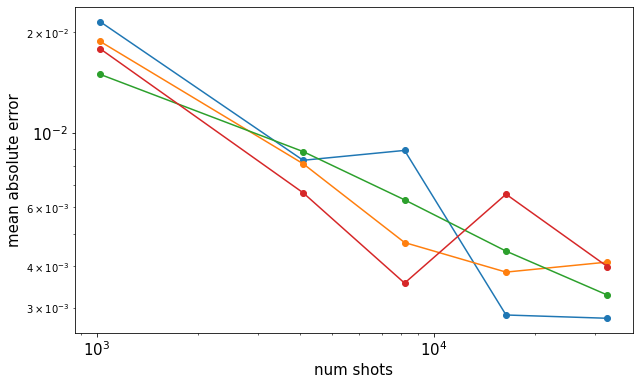

In [115]:
import matplotlib.pyplot as plt
import matplotlib
figure,ax=plt.subplots(1,figsize=(10,6))
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(labelsize=15)
ax.set_ylabel('mean absolute error',fontsize=15)
ax.set_xlabel('num shots',fontsize=15)
ax.plot(num_shots_arr,estmDMerr,label='controlVariate',marker='o')
plt.savefig('DMerrs.png')

In [5]:
def Energy(params,H=None):
    backend=Aer.get_backend('statevector_simulator')
    circ=var_form_base.construct_circuit(parameters=params)
    stateVector_0=execute(circ,backend,shots=1024).result().get_statevector()
    if (H is None):
        E=numpy.conjugate(stateVector_0)@Hmat@stateVector_0
    else:
        E=numpy.conjugate(stateVector_0)@H@stateVector_0
    return E

In [18]:
labels_ansatz=[]
params_ansatz=[]
#ansatz construction
with open('../'+str(U)+'/QasmVsStatevector/HF_statevector_adapt_VQE.txt','r') as f:
    lines=f.readlines()[2:]
    for line in lines:
        elems=line.split()
        labels_ansatz.append(elems[1])
        params_ansatz.append(float(elems[3]))

In [20]:
HFcirc,HFstate=HF_init_state(U)
var_form_base=UCCSD(8,4,initial_state=HFcirc,two_qubit_reduction=False,qubit_mapping='jordan_wigner')
var_form_base.manage_hopping_operators()
for i in range(len(labels_ansatz)):
        var_form_base.push_hopping_operator(WeightedPauliOperator([[1j,Pauli.from_label(labels_ansatz[i])]]))

Final Hartree Fock Energy -18.788335371650852


In [30]:
def constructFromParams():
    params_arr=[]
    E_arr=[]
    Eexact_arr=[]
    adaptRDMs=[]
    distRDMs=[]
    with open('output.txt','r') as f:
        lines=f.readlines()
        for line in lines:
            elems=line.split('#')
            params_arr.append(eval(elems[0]))
            print(len(params_arr[0]))
            E_arr.append(float(elems[1]))
            Eexact_arr.append(Energy(params_arr[-1]).real)
            circ=var_form_base.construct_circuit(params_arr[-1])
            state=execute(circ,Aer.get_backend('statevector_simulator'),shots=1024).result().get_statevector()
            global_phase=state[numpy.abs(state)>1e-7][0]/numpy.conjugate(state[numpy.abs(state)>1e-7][0])
            state=state/numpy.sqrt(global_phase)
            print(state@Hmat@state)
            adaptRDMs.append(M(state))
            distRDMs.append(dist(adaptRDMs[-1],exactRDM))
            print("distance between RDMs",distRDMs[-1])
    return adaptRDMs,distRDMs,E_arr,params_arr,Eexact_arr          

In [31]:
adaptRDMs,distRDMs,E_arr,params_arr,Eexact_arr = constructFromParams()

35
(-18.814011740793646-8.919407645062019e-15j)
distance between RDMs 0.08455414666001332
35
(-18.841535760790336+1.0065062463642007e-14j)
distance between RDMs 0.08340840788343229
35
(-18.861537545481227-1.4636364105795336e-11j)
distance between RDMs 0.07947778381584195
35
(-18.8833015657937-3.1355113721039157e-12j)
distance between RDMs 0.07632002244231721
35
(-18.898646810595373+2.9252530973561105e-13j)
distance between RDMs 0.07468903957556261
35
(-18.913718852137784+5.99719674584161e-14j)
distance between RDMs 0.07131077357717369
35
(-18.93278996405413-3.201562514809238e-13j)
distance between RDMs 0.06978032739523302
35
(-18.947218611365468-1.7021714581390996e-12j)
distance between RDMs 0.07714504475132493
35
(-18.961792011028106-6.644224969620291e-13j)
distance between RDMs 0.06503568542384888
35
(-18.976418177190766+2.7662830768291638e-11j)
distance between RDMs 0.06323241096398513
35
(-18.98851478699781+3.471988914000628e-13j)
distance between RDMs 0.06206884829638067
35
(-19.0

(-19.165056194380128+2.961951035996486e-13j)
distance between RDMs 0.015184647344078173
35
(-19.165203154174304-2.2135840124817314e-14j)
distance between RDMs 0.01667158404904474
35
(-19.164313323387006+1.790594526770668e-13j)
distance between RDMs 0.015864078447451198
35
(-19.164333163612074-2.522326899370431e-11j)
distance between RDMs 0.018904859810494144
35
(-19.1650486469798+5.289742184047839e-14j)
distance between RDMs 0.018119946392371
35
(-19.166073772905946-3.3582146775545276e-13j)
distance between RDMs 0.020508804880056873
35
(-19.166212898434953-4.252196633057811e-12j)
distance between RDMs 0.02184371694328536
35
(-19.167199088656503+3.8860685280381986e-13j)
distance between RDMs 0.02717425258031038
35
(-19.167508814788278-4.090834476848044e-14j)
distance between RDMs 0.022769871011338663
35
(-19.16806653592955-4.5425539229795674e-12j)
distance between RDMs 0.022613596019757147
35
(-19.168631752221227-7.158933829246576e-14j)
distance between RDMs 0.026950011123824058
35
(-19

(-19.17801597334218-9.795718402680799e-14j)
distance between RDMs 0.019731415250522084
35
(-19.17891657535897-3.3840221159994865e-13j)
distance between RDMs 0.02238921282013974
35
(-19.178213824815263+9.512475064837737e-12j)
distance between RDMs 0.021655901074742523
35
(-19.17892920169088+6.494833537231565e-13j)
distance between RDMs 0.020343891303778897
35
(-19.1789325468352-1.8959984404374245e-12j)
distance between RDMs 0.020218310614131298
35
(-19.179262972792372+9.425281368145152e-13j)
distance between RDMs 0.01984206114125247
35
(-19.17841438241299-7.054282165417755e-13j)
distance between RDMs 0.017609975361945394
35
(-19.17737195809926-7.637575954064519e-13j)
distance between RDMs 0.019184386766805735
35
(-19.17742619806053+4.0055490376910505e-13j)
distance between RDMs 0.01944096103457369
35
(-19.178471839575725+6.8370219712590626e-12j)
distance between RDMs 0.02052767548294468
35
(-19.1787198289921-1.005932300339272e-12j)
distance between RDMs 0.020656477959480127
35
(-19.1787

In [90]:
# #statevector implementation
# adaptRDMs=[]
# distRDMs=[]
# backend=Aer.get_backend('statevector_simulator')
# with open('../%s/QasmVsStatevector/adaptRunDataQasm.txt'%str(U),'r') as f:
#     lines=f.readlines()
#     for i in tqdm(range(len(lines))):
#         elems=eval(lines[i])
#         circ=var_form_base.construct_circuit(elems)
#         state=execute(circ,backend,shots=1024).result().get_statevector()
#         global_phase=state[numpy.abs(state)>1e-7][0]/numpy.conjugate(state[numpy.abs(state)>1e-7][0])
#         state=state/numpy.sqrt(global_phase)
#         print(state@Hmat@state)
#         adaptRDMs.append(M(state))
#         distRDMs.append(dist(adaptRDMs[-1],exactRDM))
#         print("distance between RDMs",distRDMs[-1])

$\rho=\sum_{\sigma\sigma'}c^{\dagger}_{i\sigma}c_{j\sigma'}$

In [39]:
numpy.set_printoptions(precision=5,suppress=True)
adaptRDMs[-1],exactRDM

(array([[ 0.75837+0.j,  0.     -0.j,  0.34172-0.j,  0.     +0.j,
         -0.     -0.j,  0.     -0.j,  0.     +0.j,  0.     +0.j],
        [ 0.     +0.j,  0.77848+0.j, -0.     -0.j,  0.32785-0.j,
          0.     -0.j, -0.     +0.j, -0.     +0.j, -0.     -0.j],
        [ 0.34172+0.j, -0.     +0.j,  0.24233+0.j, -0.     +0.j,
         -0.     -0.j, -0.     +0.j,  0.     -0.j, -0.     +0.j],
        [ 0.     -0.j,  0.32785+0.j, -0.     -0.j,  0.22095+0.j,
         -0.     +0.j,  0.     -0.j, -0.     +0.j,  0.     -0.j],
        [-0.     +0.j,  0.     +0.j, -0.     +0.j, -0.     -0.j,
          0.74702+0.j,  0.     +0.j,  0.35127-0.j,  0.     +0.j],
        [ 0.     +0.j, -0.     -0.j, -0.     -0.j,  0.     +0.j,
          0.     -0.j,  0.73015+0.j, -0.     -0.j,  0.36189-0.j],
        [ 0.     -0.j, -0.     -0.j,  0.     +0.j, -0.     -0.j,
          0.35127+0.j, -0.     +0.j,  0.25262+0.j, -0.     -0.j],
        [ 0.     -0.j, -0.     +0.j, -0.     -0.j,  0.     +0.j,
          0.     -

In [37]:
Eexact_arr-Eg 

array([0.37097, 0.34345, 0.32345, 0.30168, 0.28634, 0.27127, 0.2522 ,
       0.23777, 0.22319, 0.20857, 0.19647, 0.18311, 0.17526, 0.16614,
       0.15894, 0.15161, 0.14497, 0.13766, 0.13127, 0.12667, 0.12365,
       0.11579, 0.11195, 0.10731, 0.10308, 0.10044, 0.0977 , 0.09156,
       0.08663, 0.08401, 0.08228, 0.07961, 0.07679, 0.07234, 0.06939,
       0.06777, 0.06534, 0.06403, 0.06316, 0.05985, 0.05942, 0.0595 ,
       0.05566, 0.05507, 0.05261, 0.05069, 0.04988, 0.04802, 0.04857,
       0.04731, 0.04674, 0.04456, 0.04457, 0.04468, 0.04399, 0.04429,
       0.04182, 0.04223, 0.04073, 0.04096, 0.04081, 0.03855, 0.03792,
       0.03707, 0.03636, 0.03642, 0.03826, 0.03935, 0.03561, 0.03532,
       0.03475, 0.03333, 0.03251, 0.03202, 0.03005, 0.02772, 0.02661,
       0.02549, 0.02629, 0.02894, 0.02685, 0.02508, 0.02366, 0.02128,
       0.02135, 0.02008, 0.01973, 0.02044, 0.02383, 0.02105, 0.01929,
       0.01993, 0.01978, 0.02067, 0.02065, 0.01994, 0.01891, 0.01877,
       0.01779, 0.01

In [40]:
import matplotlib.pyplot as plt

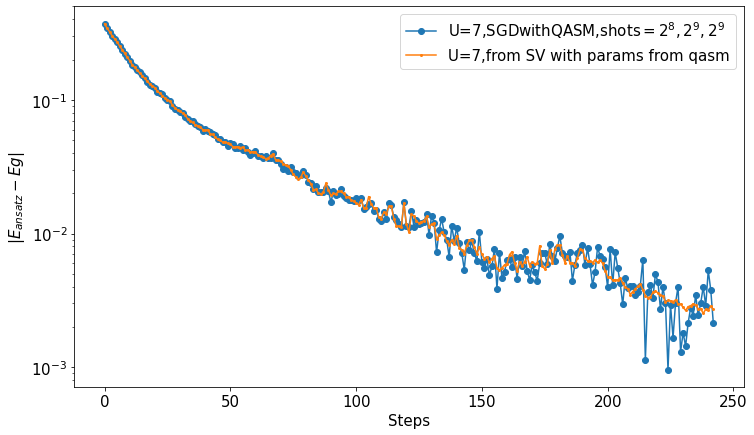

In [60]:
figure,ax=plt.subplots(1,figsize = (12,7))
ax.set_xlabel("Steps",fontsize=15)
ax.set_ylabel(r'$|E_{ansatz}-Eg|$',fontsize=15)
ax.plot(numpy.abs(numpy.array(E_arr)-Eg),marker='o',linestyle='-',label=r'U='+str(U)+',SGDwithQASM,shots$=2^{8},2^{9},2^{9}$')
ax.plot(numpy.abs(numpy.array(Eexact_arr)-Eg),marker='o',markersize=2,linestyle='-',label='U='+str(U)+',from SV with params from qasm')    
ax.set_yscale('log')
ax.tick_params(labelsize=15)
ax.legend(fontsize=15)
plt.savefig("../"+str(U)+"/SGDqasmSMO-U-%s.png"%str(U)) 

In [46]:
error_one_body_DM(adaptRDMs,exactRDM,U)

True

In [49]:
with open('../7/qasm_error_one_body_dm_SGD.txt','r') as f:
    lines=f.readlines()
    ind=0
    dm_error_arr=numpy.zeros((len(lines[1:]),12))
    for line in lines[1:]:
        elems=line.split()
        for i in range(len(elems)):
            dm_error_arr[ind][i]=float(elems[i])
        ind=ind+1   

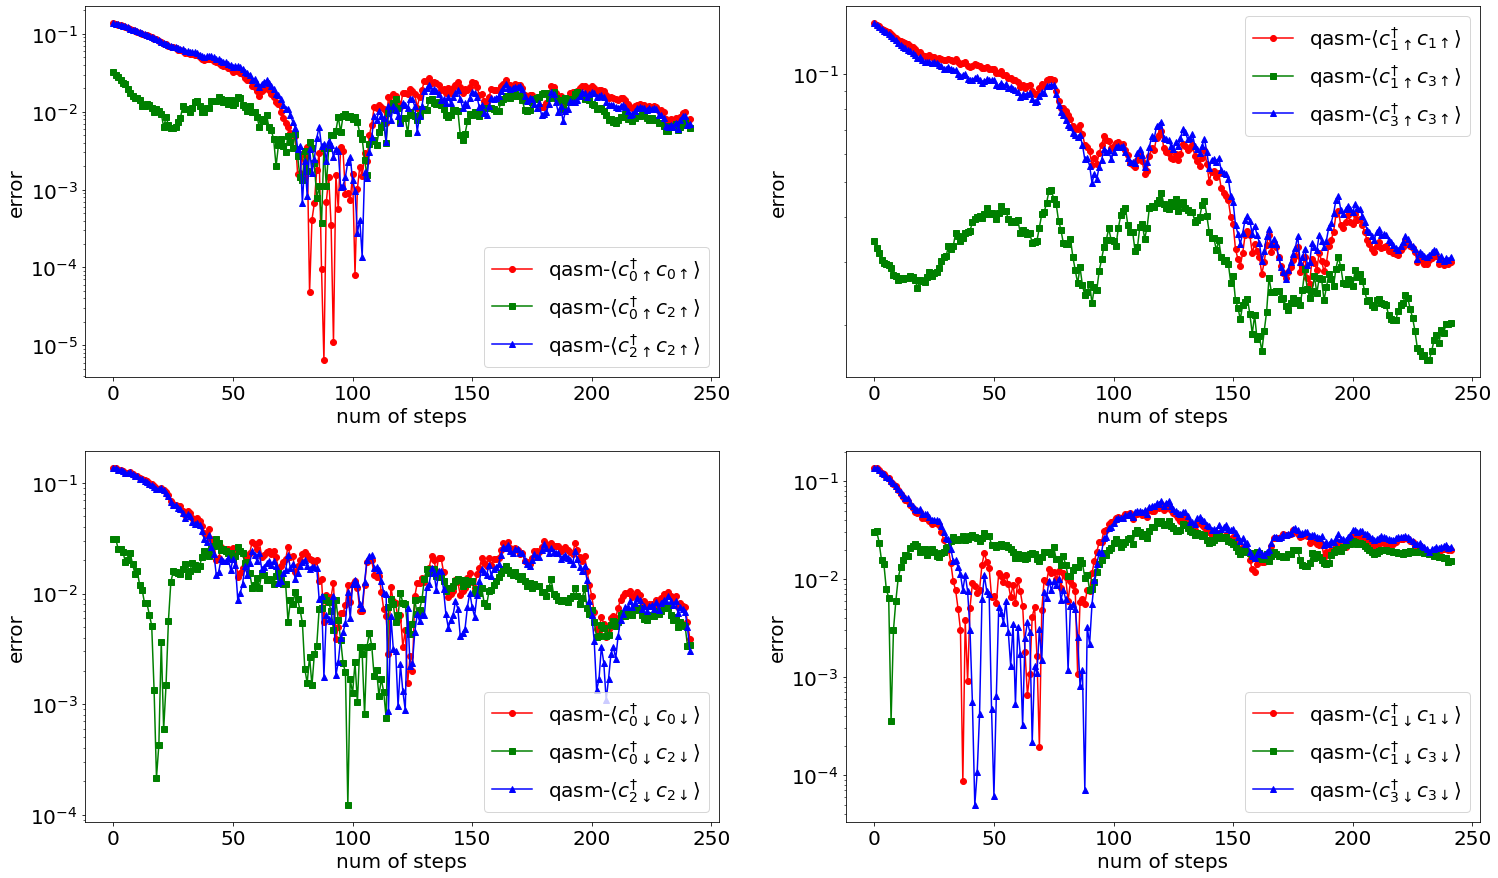

In [58]:
figure,ax=plt.subplots(2,2,figsize = (25,15))
error_arr=dm_error_arr
ax[0][0].set_xlabel("num of steps",fontsize=20)
ax[0][0].set_ylabel("error",fontsize=20)
ax[0][0].set_yscale('log')
ax[0][1].set_xlabel("num of steps",fontsize=20)
ax[0][1].set_ylabel("error",fontsize=20)
ax[0][1].set_yscale('log')
ax[1][0].set_xlabel("num of steps",fontsize=20)
ax[1][0].set_ylabel("error",fontsize=20)
ax[1][0].set_yscale('log')
ax[1][1].set_xlabel("num of steps",fontsize=20)
ax[1][1].set_ylabel("error",fontsize=20)
ax[1][1].set_yscale('log')
ax[0][0].tick_params(labelsize=20)
ax[0][1].tick_params(labelsize=20)
ax[1][0].tick_params(labelsize=20)
ax[1][1].tick_params(labelsize=20)
ax[0][0].plot(error_arr[:,0],label=r'qasm-$\langle c^{\dagger}_{0\uparrow}c_{0\uparrow}\rangle$',color='r',marker='o')
ax[0][0].plot(error_arr[:,1],label=r'qasm-$\langle c^{\dagger}_{0\uparrow}c_{2\uparrow}\rangle$',color='g',marker='s')
ax[0][0].plot(error_arr[:,4],label=r'qasm-$\langle c^{\dagger}_{2\uparrow}c_{2\uparrow}\rangle$',color='b',marker='^')
ax[0][1].plot(error_arr[:,2],label=r'qasm-$\langle c^{\dagger}_{1\uparrow}c_{1\uparrow}\rangle$',color='r',marker='o')
ax[0][1].plot(error_arr[:,3],label=r'qasm-$\langle c^{\dagger}_{1\uparrow}c_{3\uparrow}\rangle$',color='g',marker='s')
ax[0][1].plot(error_arr[:,5],label=r'qasm-$\langle c^{\dagger}_{3\uparrow}c_{3\uparrow}\rangle$',color='b',marker='^')
ax[1][0].plot(error_arr[:,6],label=r'qasm-$\langle c^{\dagger}_{0\downarrow}c_{0\downarrow}\rangle$',color='r',marker='o')
ax[1][0].plot(error_arr[:,7],label=r'qasm-$\langle c^{\dagger}_{0\downarrow}c_{2\downarrow}\rangle$',color='g',marker='s')
ax[1][0].plot(error_arr[:,10],label=r'qasm-$\langle c^{\dagger}_{2\downarrow}c_{2\downarrow}\rangle$',color='b',marker='^')
ax[1][1].plot(error_arr[:,8],label=r'qasm-$\langle c^{\dagger}_{1\downarrow}c_{1\downarrow}\rangle$',color='r',marker='o')
ax[1][1].plot(error_arr[:,9],label=r'qasm-$\langle c^{\dagger}_{1\downarrow}c_{3\downarrow}\rangle$',color='g',marker='s')
ax[1][1].plot(error_arr[:,11],label=r'qasm-$\langle c^{\dagger}_{3\downarrow}c_{3\downarrow}\rangle$',color='b',marker='^')
ax[0][0].legend(fontsize=20)
ax[0][1].legend(fontsize=20)
ax[1][0].legend(fontsize=20)
ax[1][1].legend(fontsize=20)
plt.savefig("../"+str(U)+"/sgd_qasmRDM-errorU=7.png")